In [ ]:
! pip3 install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 38.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm.notebook import tqdm
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report
)

from transformers import (
    AutoTokenizer,
    AutoModel,
    get_linear_schedule_with_warmup
)

project_dir = './'

In [ ]:
! nvidia-smi

Wed Oct 25 06:52:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data

In [ ]:
df = pd.read_csv(project_dir + 'full_data.csv')
print(df.shape)
df.head()

(1808, 16)


,ID,Text,Reconnaissance,Resource Development,Initial Access,Execution,Persistence,Privilege Escalation,Defense Evasion,Credential Access,Discovery,Lateral Movement,Collection,Command and Control,Exfiltration,Impact
0,CVE-2020-5421,"In Spring Framework versions 5.2.0 - 5.2.8, 5....",0,0,0,1,0,1,0,1,0,0,1,0,0,0
1,CVE-2020-5413,Spring Integration framework provides Kryo Cod...,0,0,1,1,0,1,0,0,0,0,0,0,0,0
2,CVE-2020-28035,WordPress before 5.5.2 allows attackers to gai...,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,CVE-2017-13715,The __skb_flow_dissect function in net/core/fl...,0,0,0,1,0,0,1,0,0,0,0,0,0,1
4,CVE-2014-2523,net/netfilter/nf_conntrack_proto_dccp.c in the...,0,0,0,1,0,0,1,0,0,0,0,0,0,1


In [ ]:
tactics = df.columns[2:]
df_filtered = df.drop(df[(df[tactics] == 0).all(axis=1)].index)

df = df_filtered
print(df.shape)

(1718, 16)


In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

final_texts = []
final_labels = []

def clean_abstract(text):
    # Replace versions with the word "VERSION"
    version_pattern = r"\d+(\.\d+)+"
    updated_text = re.sub(version_pattern, "version", text)

    # Replace other CVE references
    version_pattern = r'CVE-\d{1,5}-\d{1,5}'
    updated_text = re.sub(version_pattern, "CVE", updated_text)

    return updated_text

def get_texts(df):
    texts = df['Text'].apply(clean_abstract)
    texts = texts.values.tolist()
    return texts

def get_labels(df):
    labels = df.iloc[:, 2:].values
    return labels

def get_ids(df):
    ids = df['ID'].values.tolist()
    return ids

texts = get_texts(df)
labels = get_labels(df)
ids = get_ids(df)

for text, label, id in zip(texts[:5], labels[:5], ids):
    print(f'Text -\t{text}')
    print(f'ID -\t{id}')
    print(f'Labels -\t{label}')
    print()

Text -	In Spring Framework versions version - version, version - version, version - version, version - version, and older unsupported versions, the protections against RFD attacks from CVE may be bypassed depending on the browser used through the use of a jsessionid path parameter
ID -	CVE-2020-5421
Labels -	[0 0 0 1 0 1 0 1 0 0 1 0 0 0]

Text -	Spring Integration framework provides Kryo Codec implementations as an alternative for Java (de)serialization. When Kryo is configured with default options, all unregistered classes are resolved on demand. This leads to the "deserialization gadgets" exploit when provided data contains malicious code for execution during deserialization. In order to protect against this type of attack, Kryo can be configured to require a set of trusted classes for (de)serialization. Spring Integration should be proactive against blocking unknown "deserialization gadgets" when configuring Kryo in code
ID -	CVE-2020-5413
Labels -	[0 0 1 1 0 1 0 0 0 0 0 0 0 0]

Tex

## Exploratory Data Analysis

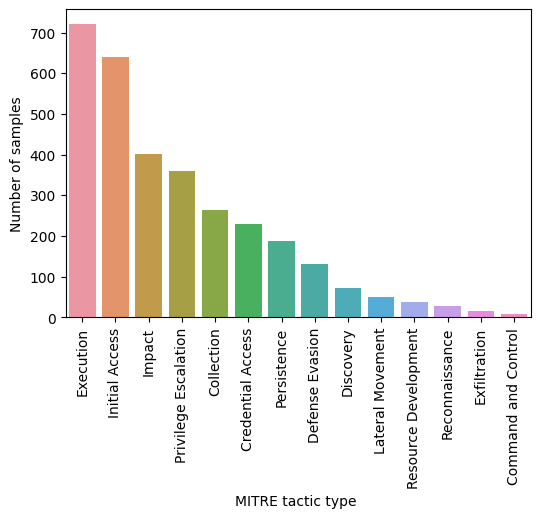

In [ ]:
categories = df.iloc[:, 2:].sum()
plt.figure(figsize=(6, 4))

sorted_categories = categories.sort_values(ascending=False).index
ax = sns.barplot(x=sorted_categories, y=categories[sorted_categories].values)

plt.ylabel('Number of samples')
plt.xlabel('MITRE tactic type ')
plt.xticks(rotation=90)
plt.show()

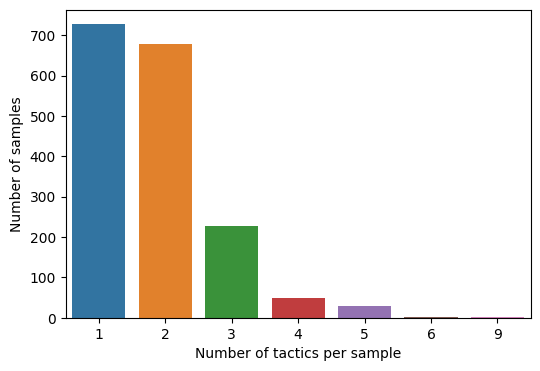

In [ ]:
row_sums = df.iloc[:, 2:].sum(axis=1)
multilabel_counts = row_sums.value_counts()

sorted_counts = multilabel_counts.sort_index()
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=sorted_counts.index, y=sorted_counts.values)

plt.ylabel('Number of samples')
plt.xlabel('Number of tactics per sample')
plt.show()

<BarContainer object of 1718 artists>

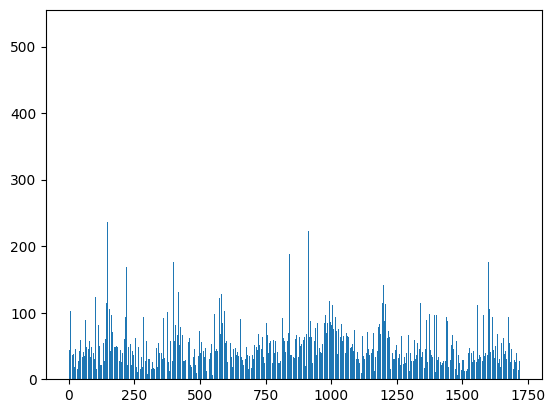

In [ ]:
y = [len(t.split()) for t in texts]
x = range(0, len(y))
plt.bar(x, y)

# Config

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
from transformers import AutoTokenizer, AutoModelForMaskedLM


class Config:
    def __init__(self):
        super(Config, self).__init__()

        self.SEED = 42
        self.MODEL_PATH = 'jackaduma/SecRoBERTa'
        self.NUM_LABELS = 14

        self.TOKENIZER = AutoTokenizer.from_pretrained(self.MODEL_PATH)
        self.MAX_LENGTH = 320
        self.BATCH_SIZE = 16
        self.VALIDATION_SPLIT = 0.20

        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.FULL_FINETUNING = True
        self.LR = 3e-5
        self.OPTIMIZER = 'AdamW'
        self.CRITERION = 'BCEWithLogitsLoss'
        self.N_VALIDATE_DUR_TRAIN = 3
        self.N_WARMUP = 0
        self.SAVE_BEST_ONLY = True
        self.EPOCHS = 15

config = Config()

## Dataset & Dataloader

In [ ]:
class TransformerDataset(Dataset):
    def __init__(self, df, indices, set_type=None):
        super(TransformerDataset, self).__init__()

        df = df.iloc[indices]
        self.texts = get_texts(df)
        self.set_type = set_type
        if self.set_type != 'test':
            self.labels = get_labels(df)

        self.tokenizer = config.TOKENIZER
        self.max_length = config.MAX_LENGTH

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        tokenized = self.tokenizer.encode_plus(
            self.texts[index],
            max_length=self.max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )

        input_ids = tokenized['input_ids'].squeeze()
        attention_mask = tokenized['attention_mask'].squeeze()

        if self.set_type != 'test':
            return {
                'input_ids': input_ids.long(),
                'attention_mask': attention_mask.long(),
                'labels': torch.Tensor(self.labels[index]).float(),
            }

        return {
            'input_ids': input_ids.long(),
            'attention_mask': attention_mask.long(),
        }

## Train-val Split


In [ ]:
df_train = pd.read_csv(project_dir + 'train_data.csv')
print(df_train.shape)
df_train.head()

(1387, 16)


,ID,Text,Reconnaissance,Resource Development,Initial Access,Execution,Persistence,Privilege Escalation,Defense Evasion,Credential Access,Discovery,Lateral Movement,Collection,Command and Control,Exfiltration,Impact
0,CVE-2020-15100,"In freewvs before 0.1.1, a user could create a...",0,0,1,0,1,0,0,0,0,0,0,0,0,1
1,CVE-2017-0262,"Microsoft Office 2010 SP2, Office 2013 SP1, an...",0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,CVE-2021-33709,A vulnerability has been identified in Teamcen...,0,0,0,1,0,0,0,1,0,0,0,0,0,0
3,CVE-2021-3393,An information leak was discovered in postgres...,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,CVE-2022-26850,When creating or updating credentials for sing...,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
df_test = pd.read_csv(project_dir + 'test_data.csv')
print(df_test.shape)
df_test.head()

(331, 16)


,ID,Text,Reconnaissance,Resource Development,Initial Access,Execution,Persistence,Privilege Escalation,Defense Evasion,Credential Access,Discovery,Lateral Movement,Collection,Command and Control,Exfiltration,Impact
0,CVE-2021-34803,TeamViewer before 14.7.48644 on Windows loads ...,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,CVE-2016-0034,Microsoft Silverlight 5 before 5.1.41212.0 mis...,0,0,1,1,0,0,0,0,0,0,0,0,0,1
2,CVE-2015-5123,Use-after-free vulnerability in the BitmapData...,0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,CVE-2021-23964,Mozilla developers reported memory safety bugs...,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,CVE-2020-5812,Nessus AMI versions 8.12.0 and earlier were fo...,0,0,1,0,0,0,0,1,0,0,1,0,0,0


In [ ]:
train_data = TransformerDataset(df_train,  range(len(df_train)))
val_data = TransformerDataset(df_test, range(len(df_test)))

train_dataloader = DataLoader(train_data, batch_size=config.BATCH_SIZE)
val_dataloader = DataLoader(val_data, batch_size=config.BATCH_SIZE)

b = next(iter(train_dataloader))
for k, v in b.items():
    print(f'{k} shape: {v.shape}')

input_ids shape: torch.Size([16, 320])
attention_mask shape: torch.Size([16, 320])
labels shape: torch.Size([16, 14])


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Model

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.transformer_model = AutoModel.from_pretrained(
            config.MODEL_PATH
        )
        self.dropout = nn.Dropout(0.3)

        self.output = nn.Linear(768, config.NUM_LABELS)

    def forward(
        self,
        input_ids,
        attention_mask=None,
        token_type_ids=None
        ):

        _, o2 = self.transformer_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=False
        )

        x = self.dropout(o2)
        out = self.output(x)

        return out

In [ ]:
device = config.DEVICE
device

device(type='cuda')

# Train and test



In [ ]:
def compute_metrics(predicted_y, true_y, metric_function, columns, limit):
  results = pd.DataFrame(columns = columns)
  if (metric_function == accuracy_score):
    results.loc[len(results)] = metric_function(true_y, predicted_y)
  else:
    results.loc[len(results)] = metric_function(true_y, predicted_y, average=None)

  sorted_results = results.sort_values(by=0, axis=1, ascending=False)

  print("Sorted results")
  sorted_results.head()
  return sorted_results.iloc[:, :limit]


def print_F1_based_on_distribution(y_true, y_pred, Y, columns):
  fig,ax = plt.subplots()

  results = pd.DataFrame(columns = columns)
  results.loc[len(results)] = f1_score(y_true, y_pred, average=None)

  Y_count = Y.apply(np.sum, axis=0)
  Y_count_sorted = Y_count.sort_values(ascending=False)

  ax.bar(Y_count_sorted.index, Y_count_sorted.values)
  ax.set_xlabel("Tactics")
  ax.set_ylabel("Number of CVEs")
  plt.xticks(rotation=90)

  ax2=ax.twinx()
  ax2.plot(Y_count_sorted.index, results[Y_count_sorted.index].iloc[0], color='red')
  ax2.set_ylabel("F1 Score")

  ax = plt.gca()
  plt.show()

In [ ]:
BEST_F1 = 0
BEST_TRUE = []
BEST_PREDICTED = []

def val(model, val_dataloader, criterion):
    global BEST_F1, BEST_TRUE, BEST_PREDICTED

    val_loss = 0
    true, pred = [], []

    model.eval()

    for step, batch in enumerate(val_dataloader):
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.no_grad():
            logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)

            loss = criterion(logits, b_labels)
            val_loss += loss.item()

            logits = torch.sigmoid(logits)
            logits = np.round(logits.cpu().numpy())
            labels = b_labels.cpu().numpy()

            pred.extend(logits)
            true.extend(labels)

    avg_val_loss = val_loss / len(val_dataloader)
    print('Val loss:', avg_val_loss)
    print('Val accuracy:', accuracy_score(true, pred))

    print('Val precision:', precision_score(true, pred, average='weighted'))
    print('Val recall:', recall_score(true, pred, average='weighted'))

    val_micro_f1_score = f1_score(true, pred, average='micro')
    print('Val micro f1 score:', val_micro_f1_score)

    val_macro_f1_score = f1_score(true, pred, average='macro')
    print('Val macro f1 score:', val_macro_f1_score)

    val_weighted_f1_score = f1_score(true, pred, average='weighted')
    print('Val weighted f1 score:', val_weighted_f1_score)

    if (val_weighted_f1_score > BEST_F1):
      BEST_F1 = val_weighted_f1_score
      BEST_TRUE = true
      BEST_PREDICTED = pred

    return val_weighted_f1_score


def train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epoch):
    nv = config.N_VALIDATE_DUR_TRAIN
    temp = len(train_dataloader) // nv
    temp = temp - (temp % 100)
    validate_at_steps = [temp * x for x in range(1, nv + 1)]

    train_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader,
                                      desc='Epoch ' + str(epoch))):
        model.train()

        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        optimizer.zero_grad()

        logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)

        loss = criterion(logits, b_labels)
        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        scheduler.step()

        if step in validate_at_steps:
            print(f'-- Step: {step}')
            _ = val(model, val_dataloader, criterion)

    avg_train_loss = train_loss / len(train_dataloader)
    print('Training loss:', avg_train_loss)

# Run

In [ ]:
def run():
    torch.manual_seed(config.SEED)

    criterion = nn.BCEWithLogitsLoss()

    if config.FULL_FINETUNING:
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.001,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        optimizer = optim.AdamW(optimizer_parameters, lr=config.LR)

    num_training_steps = len(train_dataloader) * config.EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    max_val_weighted_f1_score = float('-inf')
    for epoch in range(config.EPOCHS):
        train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epoch)
        val_weighted_f1_score = val(model, val_dataloader, criterion)

        if config.SAVE_BEST_ONLY:
            if val_weighted_f1_score > max_val_weighted_f1_score:
                best_model = copy.deepcopy(model)

                model_name = 'secroberta_best_model'
                torch.save(best_model.state_dict(), model_name + '.pt')

                print(f'--- Best Model. Val: {max_val_weighted_f1_score} -> {val_weighted_f1_score}')
                max_val_weighted_f1_score = val_weighted_f1_score

    return best_model, max_val_weighted_f1_score

In [ ]:
model = Model()
model.to(device);

In [ ]:
best_model, best_val_weighted_f1_score = run()

Epoch 0:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.6543156930378505
Val accuracy: 0.0
Val precision: 0.21660695453069514
Val recall: 0.19936204146730463
Val micro f1 score: 0.1278772378516624
Val macro f1 score: 0.08554179216504772
Val weighted f1 score: 0.15850103281745312


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.3497278656082592
Val loss: 0.31544005941777004
Val accuracy: 0.0
Val precision: 0.0
Val recall: 0.0
Val micro f1 score: 0.0
Val macro f1 score: 0.0
Val weighted f1 score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- Best Model. Val: -inf -> 0.0


Epoch 1:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.31505071620146435
Val accuracy: 0.0
Val precision: 0.0
Val recall: 0.0
Val micro f1 score: 0.0
Val macro f1 score: 0.0
Val weighted f1 score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.2923590397012645
Val loss: 0.2775288884128843
Val accuracy: 0.1661631419939577
Val precision: 0.5871861020000247
Val recall: 0.2886762360446571
Val micro f1 score: 0.41136363636363626
Val macro f1 score: 0.17052881912562898
Val weighted f1 score: 0.37107667503740405


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- Best Model. Val: 0.0 -> 0.37107667503740405


Epoch 2:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.27707809138865697
Val accuracy: 0.18429003021148035
Val precision: 0.5783337737571147
Val recall: 0.31100478468899523
Val micro f1 score: 0.4314159292035399
Val macro f1 score: 0.17919847319253093
Val weighted f1 score: 0.3889692827788376


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.25036247297265063
Val loss: 0.26725226640701294
Val accuracy: 0.2084592145015106
Val precision: 0.6473186243889041
Val recall: 0.4098883572567783
Val micro f1 score: 0.5191919191919192
Val macro f1 score: 0.238268400286374
Val weighted f1 score: 0.4813660333539661


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- Best Model. Val: 0.37107667503740405 -> 0.4813660333539661


Epoch 3:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.26741123767126174
Val accuracy: 0.20241691842900303
Val precision: 0.6408221376816395
Val recall: 0.4354066985645933
Val micro f1 score: 0.5352941176470588
Val macro f1 score: 0.24445361845780025
Val weighted f1 score: 0.49437257343588065


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.20898523772584982
Val loss: 0.26926915631407783
Val accuracy: 0.21450151057401812
Val precision: 0.6176332414332918
Val recall: 0.44019138755980863
Val micro f1 score: 0.5354025218234724
Val macro f1 score: 0.26292343023095405
Val weighted f1 score: 0.5024134528275496


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- Best Model. Val: 0.4813660333539661 -> 0.5024134528275496


Epoch 4:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.2706156777484076
Val accuracy: 0.2175226586102719
Val precision: 0.6118239305479034
Val recall: 0.45933014354066987
Val micro f1 score: 0.5470085470085471
Val macro f1 score: 0.2665617693642111
Val weighted f1 score: 0.5116865046663942


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.16865023139907026
Val loss: 0.27634818568116143
Val accuracy: 0.22054380664652568
Val precision: 0.5868654714710275
Val recall: 0.46570972886762363
Val micro f1 score: 0.5382488479262673
Val macro f1 score: 0.245250253424014
Val weighted f1 score: 0.49413115783221473


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.276578304313478
Val accuracy: 0.22054380664652568
Val precision: 0.5816756424431594
Val recall: 0.45933014354066987
Val micro f1 score: 0.5333333333333333
Val macro f1 score: 0.24820430578656913
Val weighted f1 score: 0.4936440471485287


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.1374107457954308
Val loss: 0.2806608818826221
Val accuracy: 0.22658610271903323
Val precision: 0.618985373438048
Val recall: 0.4704944178628389
Val micro f1 score: 0.5432780847145489
Val macro f1 score: 0.2611876579212543
Val weighted f1 score: 0.5054174738915003


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- Best Model. Val: 0.5024134528275496 -> 0.5054174738915003


Epoch 6:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.2826595249630156
Val accuracy: 0.229607250755287
Val precision: 0.5723624180278517
Val recall: 0.48484848484848486
Val micro f1 score: 0.5487364620938628
Val macro f1 score: 0.25132254617833166
Val weighted f1 score: 0.5022397345570158


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.11258397653870199
Val loss: 0.2880462457736333
Val accuracy: 0.2326283987915408
Val precision: 0.6063738730405397
Val recall: 0.48165869218500795
Val micro f1 score: 0.5480943738656987
Val macro f1 score: 0.2891365448242934
Val weighted f1 score: 0.5243259919079182


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- Best Model. Val: 0.5054174738915003 -> 0.5243259919079182


Epoch 7:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.2891834690457299
Val accuracy: 0.23867069486404835
Val precision: 0.6028780079857848
Val recall: 0.49760765550239233
Val micro f1 score: 0.5546666666666666
Val macro f1 score: 0.28688896769454747
Val weighted f1 score: 0.5251117186068259


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.0939849512330417
Val loss: 0.30353711758341106
Val accuracy: 0.1903323262839879
Val precision: 0.618497594560095
Val recall: 0.4178628389154705
Val micro f1 score: 0.5072604065827687
Val macro f1 score: 0.2734111603609978
Val weighted f1 score: 0.49099355598586447


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.299500340507144
Val accuracy: 0.20241691842900303
Val precision: 0.6301422769541242
Val recall: 0.43221690590111644
Val micro f1 score: 0.5176695319961796
Val macro f1 score: 0.28763140809357174
Val weighted f1 score: 0.5023941278204971


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.08128998026080515
Val loss: 0.30273174600941793
Val accuracy: 0.20241691842900303
Val precision: 0.660364690431566
Val recall: 0.4258373205741627
Val micro f1 score: 0.5199610516066212
Val macro f1 score: 0.28160008090776334
Val weighted f1 score: 0.5020799441187977


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.3019232004880905
Val accuracy: 0.2054380664652568
Val precision: 0.6512197208689731
Val recall: 0.43221690590111644
Val micro f1 score: 0.5221579961464354
Val macro f1 score: 0.2830047220523295
Val weighted f1 score: 0.5045850276690843


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.0729980960745236
Val loss: 0.3112255327758335
Val accuracy: 0.19939577039274925
Val precision: 0.6632107262271962
Val recall: 0.4082934609250399
Val micro f1 score: 0.5044334975369458
Val macro f1 score: 0.2930083691828934
Val weighted f1 score: 0.4908469680559909


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.3129234065612157
Val accuracy: 0.19939577039274925
Val precision: 0.6643297713799045
Val recall: 0.4098883572567783
Val micro f1 score: 0.5039215686274509
Val macro f1 score: 0.29202466756933015
Val weighted f1 score: 0.4908037775041874


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.06653698974813538
Val loss: 0.3047157795656295
Val accuracy: 0.2175226586102719
Val precision: 0.6290732119677017
Val recall: 0.4274322169059011
Val micro f1 score: 0.5178743961352656
Val macro f1 score: 0.29706544424798154
Val weighted f1 score: 0.5025541996127716


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.3056122681924275
Val accuracy: 0.21450151057401812
Val precision: 0.6312414102485873
Val recall: 0.42424242424242425
Val micro f1 score: 0.516003879728419
Val macro f1 score: 0.2968572924834106
Val weighted f1 score: 0.5014292239212709


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.06090523867771543
Val loss: 0.30545106814021156
Val accuracy: 0.2326283987915408
Val precision: 0.6141835064875222
Val recall: 0.44178628389154706
Val micro f1 score: 0.526615969581749
Val macro f1 score: 0.2801603247264752
Val weighted f1 score: 0.5072357824003146


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.3059766548020499
Val accuracy: 0.229607250755287
Val precision: 0.6162404393006001
Val recall: 0.4370015948963317
Val micro f1 score: 0.5239005736137667
Val macro f1 score: 0.2787466644248887
Val weighted f1 score: 0.5050427173846824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.0564756923965339
Val loss: 0.3051103523799351
Val accuracy: 0.25075528700906347
Val precision: 0.6262260526994657
Val recall: 0.4625199362041467
Val micro f1 score: 0.5425631431244153
Val macro f1 score: 0.2865077794725627
Val weighted f1 score: 0.5171519354269988


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 13:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.30526735314301084
Val accuracy: 0.24169184290030213
Val precision: 0.6243344519634532
Val recall: 0.45454545454545453
Val micro f1 score: 0.5357142857142857
Val macro f1 score: 0.28535595102776273
Val weighted f1 score: 0.5124130734292547


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.05410979739550886
Val loss: 0.30613651942639125
Val accuracy: 0.2537764350453172
Val precision: 0.6324369324411876
Val recall: 0.4609250398724083
Val micro f1 score: 0.5437441204139228
Val macro f1 score: 0.28320649754655997
Val weighted f1 score: 0.5152979296543364


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


-- Step: 0
Val loss: 0.3061077892780304
Val accuracy: 0.25075528700906347
Val precision: 0.6297257602964497
Val recall: 0.45933014354066987
Val micro f1 score: 0.5418626528692381
Val macro f1 score: 0.2820803873607675
Val weighted f1 score: 0.5137001360970391


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training loss: 0.051799006674481535
Val loss: 0.305669808671588
Val accuracy: 0.24773413897280966
Val precision: 0.6292615141798445
Val recall: 0.46411483253588515
Val micro f1 score: 0.544943820224719
Val macro f1 score: 0.2833401790178806
Val weighted f1 score: 0.5189739444147579


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(BEST_F1)

0.5251117186068259


In [ ]:
y_train_df = df_train.drop(df_train.columns[0:2], axis=1)

In [ ]:
f1_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, f1_score, df_test.columns[2:], 14)

Sorted results


In [ ]:
print(f1_best_metrics)

   Execution    Impact  Initial Access  Credential Access  Collection  \
0   0.704626  0.652482        0.610526           0.531646    0.464646   

   Privilege Escalation  Persistence  Defense Evasion  Discovery  \
0              0.413793     0.313725              0.2      0.125   

   Reconnaissance  Resource Development  Lateral Movement  \
0             0.0                   0.0               0.0   

   Command and Control  Exfiltration  
0                  0.0           0.0  


In [ ]:
f1_best_metrics.head()

,Execution,Impact,Initial Access,Credential Access,Collection,Privilege Escalation,Persistence,Defense Evasion,Discovery,Reconnaissance,Resource Development,Lateral Movement,Command and Control,Exfiltration
0,0.704626,0.652482,0.610526,0.531646,0.464646,0.413793,0.313725,0.2,0.125,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.metrics import (
    recall_score,
    precision_score
  )

In [ ]:
recall_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, recall_score, df_test.columns[2:], 14)
recall_best_metrics.head()

Sorted results


,Execution,Initial Access,Impact,Credential Access,Collection,Privilege Escalation,Persistence,Defense Evasion,Discovery,Reconnaissance,Resource Development,Lateral Movement,Command and Control,Exfiltration
0,0.6875,0.679688,0.575,0.456522,0.433962,0.333333,0.216216,0.115385,0.071429,0.0,0.0,0.0,0.0,0.0


In [ ]:
precision_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, precision_score, df_test.columns[2:], 14)
precision_best_metrics.head()

Sorted results


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Impact,Defense Evasion,Execution,Credential Access,Persistence,Initial Access,Privilege Escalation,Discovery,Collection,Reconnaissance,Resource Development,Lateral Movement,Command and Control,Exfiltration
0,0.754098,0.75,0.722628,0.636364,0.571429,0.55414,0.545455,0.5,0.5,0.0,0.0,0.0,0.0,0.0


In [ ]:
acc_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, accuracy_score, df_test.columns[2:], 14)
acc_best_metrics.head()

Sorted results


,Reconnaissance,Resource Development,Initial Access,Execution,Persistence,Privilege Escalation,Defense Evasion,Credential Access,Discovery,Lateral Movement,Collection,Command and Control,Exfiltration,Impact
0,0.238671,0.238671,0.238671,0.238671,0.238671,0.238671,0.238671,0.238671,0.238671,0.238671,0.238671,0.238671,0.238671,0.238671


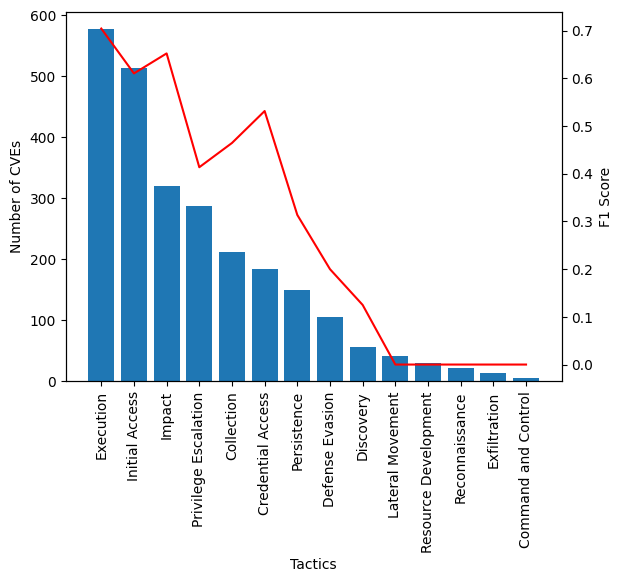

In [ ]:
print_F1_based_on_distribution(BEST_PREDICTED, BEST_TRUE, y_train_df,  df_test.columns[2:])